## Introduction

This notebook covers 
* [Data Processing](#Data-segmentation)
* [Data segmentation "Epoching"](#Data-segmentation)
* [Feature extraction](#Feature-extraction)
* [Dimensionality reduction, feature selection and feature scaling](#Dimensionality-reduction-and-feature-scaling)
* [Classification](#Classification) 

## EEG Data acquisition description 
The EEG signals have been sampled at a 256 Hz rate
Each motor imagery movement has been recorded during five seconds preceeded with five seconds of rest. 
Data (X) is saved in a matrix (Number of trials x L x Fs, number of channels)
Labels (Y) is a vector that represents the four possible classes (1, 2).

# **Add google drive files**
https://colab.research.google.com/github/ 


In [208]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '14AI0H6y15KzAey46Dq3oUDtppxfaW7LW' # URL id. 
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('gumpy.zip')

! unzip gumpy.zip
! rm -rf gumpy.zip

Archive:  gumpy.zip
replace gumpy/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: gumpy/.DS_Store         
  inflating: gumpy/gumpy/signal.py   
  inflating: gumpy/gumpy/__init__.py  
 extracting: gumpy/gumpy/version.py  
  inflating: gumpy/gumpy/utils.py    
  inflating: gumpy/gumpy/Untitled1.ipynb  
  inflating: gumpy/gumpy/Untitled.ipynb  
  inflating: gumpy/gumpy/split.py    
  inflating: gumpy/gumpy/plot.py     
  inflating: gumpy/gumpy/features.py  
  inflating: gumpy/gumpy/.DS_Store   
  inflating: gumpy/examples/.DS_Store  
  inflating: gumpy/gumpy/__pycache__/signal.cpython-35.pyc  
  inflating: gumpy/gumpy/__pycache__/__init__.cpython-37.pyc  
  inflating: gumpy/gumpy/__pycache__/__init__.cpython-36.pyc  
  inflating: gumpy/gumpy/__pycache__/__init__.cpython-35.pyc  
  inflating: gumpy/gumpy/__pycache__/version.cpython-37.pyc  
  inflating: gumpy/gumpy/__pycache__/version.cpython-36.pyc  
  inflating: gumpy/gumpy/__pycache__/version.cpython-35.pyc  
  inflatin

# **Install all dependencies**

In [209]:
file_id = '1ro8HVvReF4zP9QusMs--8j8FKUhZPYzH' # URL id. 
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('requirements.txt.zip')

! unzip requirements.txt.zip
! rm -rf requirements.txt.zip

! pip3 install -r  requirements.txt

Archive:  requirements.txt.zip
replace requirements.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: requirements.txt        


# **Import Modules**

In [0]:
import pandas as pd
import sqlite3
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import pandas as pd 
%reset -f
%matplotlib inline
import pandas as pd 
import sys, os, os.path
import sys, os, os.path
sys.path.append('./gumpy')
import numpy as np
import gumpy





# **Test Toolbox**: Display all available classifiers

In [211]:
gumpy.classification.available_classifiers

{'KNN': gumpy.classification.common.KNN,
 'LDA': gumpy.classification.common.LDA,
 'LogisticRegression': gumpy.classification.common.LogisticRegression,
 'MLP': gumpy.classification.common.MLP,
 'NaiveBayes': gumpy.classification.common.NaiveBayes,
 'QuadraticLDA': gumpy.classification.common.QuadraticLDA,
 'RandomForest': gumpy.classification.common.RandomForest,
 'SVM': gumpy.classification.common.SVM,
 'ShrinkingLDA': gumpy.classification.common.ShrinkingLDA,
 'Tree': gumpy.classification.common.Tree}

# **Read Graz Dataset**
# Import data
To import data, you have to specify the directory in which your data is stored in. For the example given here, the data is in the same directory ``/content``. 
Then, one of the classes that subclass from ``dataset`` can be used to load the data. In the example, we will use the GrazB dataset, for which ``gumpy`` already includes a corresponding class. If you have different data, simply subclass from ``gumpy.dataset.Dataset``.

In [212]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = '1ftAtJxNCSWF2pKRkd3AVcnDYsvNfLEST' # URL id. 
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('grazdata.zip')

! unzip grazdata.zip
! rm -rf grazdata.zip

Archive:  grazdata.zip
mapname:  conversion of  failed
replace B03T.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: B03T.mat                
 extracting: B05E.mat                
 extracting: B04T.mat                
 extracting: B01E.mat                
 extracting: B04E.mat                
 extracting: B06T.mat                
 extracting: B08T.mat                
 extracting: B07T.mat                
 extracting: B02T.mat                
 extracting: B03E.mat                
 extracting: B09T.mat                
 extracting: B05T.mat                
 extracting: B09E.mat                
 extracting: B01T.mat                
 extracting: B06E.mat                
 extracting: B07E.mat                
 extracting: B08E.mat                
 extracting: B02E.mat                


# **Subject Choice**

In [213]:
# First specify the location of the data and some 
# identifier that is exposed by the dataset (e.g. subject)

grazb_base_dir = '/content'
subject = 'B04'

# The next line first initializes the data structure. 
# Note that this does not yet load the data! In custom implementations
# of a dataset, this should be used to prepare file transfers, 
# for instance check if all files are available, etc.
grazb_data = gumpy.data.GrazB(grazb_base_dir, subject)

# Finally, load the dataset
grazb_data.load()

# gumpy exposes several methods to split a dataset, as shown in the examples:
# 

# **Dataset Information**

In [214]:
grazb_data.print_stats()
labels=grazb_data.labels

Data identification: GrazB-B04
EEG-data shape: (1769628, 3)
Trials data shape:  (399,)
Labels shape:  (399,)
Sampling frequency of EEG data: 250
Classes possible:  [0 1]


# Postprocess data
Usually it is necessary to postprocess the raw data before you can properly use it. ``gumpy`` provides several methods to easily do so, or provides implementations that can be adapted to your needs.

Most methods internally use other Python toolkits, for instance ``sklearn``, which is heavily used throughout ``gumpy``. Thereby, it is easy to extend ``gumpy`` with custom filters. In addition, we expect users to have to manipulate the raw data directly as shown in the following example.

## Common average re-referencing the data  to Cz
Some data is required to be re-referenced to a certain electrode. Because this may depend on your dataset, there is no common function provided by ``gumpy`` to do so. However and if sub-classed according to the documentation, you can access the raw-data directly as in the following example.

In [0]:
if 0:
    grazb_data.raw_data[:, 0] -= 2 * grazb_data.raw_data[:, 1]
    grazb_data.raw_data[:, 2] -= 2 * grazb_data.raw_data[:, 2]

## Example: Notch and Band-Pass Filters
``gumpy`` ships with several filters already implemented. They accept either raw data to be filtered, or a subclass of ``Dataset``. In the latter case, ``gumpy`` will automatically convert all channels using parameters extracted from the dataset.

In [0]:

# this returns a butter-bandpass filtered version of the entire dataset
btr_data = gumpy.signal.butter_bandpass(grazb_data, lo=2, hi=60)

# it is also possible to use filters on individual electrodes using 
# the .raw_data field of a dataset. The example here will remove a certain
# from a single electrode using a Notch filter. This example also demonstrates
# that parameters will be forwarded to the internal call to the filter, in this
# case the scipy implementation iirnotch (Note that iirnotch is only available
# in recent versions of scipy, and thus disabled in this example by default)
#notch
f0=50
Q=50
if False:
      btr_data = gumpy.signal.notch(btr_data, cutoff=f0, Q=Q)

## Normalization
Many datasets require normalization. ``gumpy`` provides functions to compute normalization either using a mean computation or via min/max computation. As with the filters, this function accepts either an instance of ``Dataset``, or raw_data. In fact, it can be used for postprocessing any row-wise data in a numpy matrix.

In [217]:



# normalize the data first
btr_data = gumpy.signal.normalize(btr_data, 'mean_std')
# let's see some statistics
print("""Normalized Data:
  Mean    = {:.3f}
  Min     = {:.3f}
  Max     = {:.3f}
  Std.Dev = {:.3f}""".format(
  np.nanmean(btr_data),np.nanmin(btr_data),np.nanmax(btr_data),np.nanstd(btr_data)
))



Normalized Data:
  Mean    = -0.000
  Min     = -23.093
  Max     = 19.032
  Std.Dev = 1.000


# Plotting and Feature Extraction

Certainly you wish to plot results. ``gumpy`` provides several functions that show how to implement visualizations. For this purpose it heavily relies on ``matplotlib``, ``pandas``, and ``seaborn``. The following examples will show several of the implemented signal processing methods as well as their corresponding plotting functions. Moreover, the examples will show you how to extract features

That said, let's start with a simple visualization where we access the filtered data from above to show you how to access the data and plot it.

Text(0.5,1,' Filtered Data')

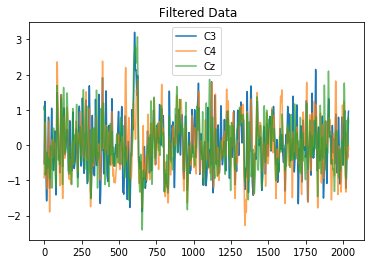

In [218]:
%matplotlib inline
import matplotlib.pyplot as plt 

# Plot after filtering with a butter bandpass (ignore normalization)
plt.figure()
plt.clf()
plt.plot(btr_data[grazb_data.trials[0]: grazb_data.trials[1], 0], label='C3')
plt.plot(btr_data[grazb_data.trials[0]: grazb_data.trials[1], 1], alpha=0.7, label='C4')
plt.plot(btr_data[grazb_data.trials[0]: grazb_data.trials[1], 2], alpha=0.7, label='Cz')
plt.legend()
plt.title(" Filtered Data")

## EEG band visualization
Using ``gumpy``'s filters and the provided method, it is easy to filter and subsequently plot the  EEG bands of a trial.

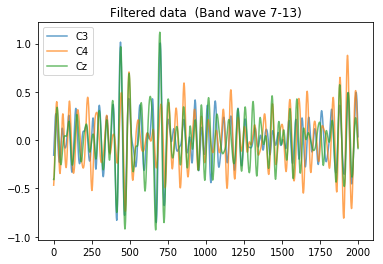

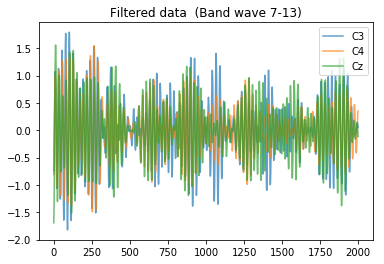

In [220]:
# determine the trial that we wish to plot
n_trial = 120
# now specify the alpha and beta cutoff frequencies
lo_a, lo_b = 7, 16
hi_a, hi_b = 13, 24

# first step is to filter the data
flt_a = gumpy.signal.butter_bandpass(btr_data, lo=lo_a, hi=hi_a)
flt_b = gumpy.signal.butter_bandpass(btr_data, lo=lo_b, hi=hi_b)

# finally we can visualize the data
gumpy.plot.EEG_bandwave_visualizer(grazb_data, flt_a, n_trial, lo_a, hi_a)
gumpy.plot.EEG_bandwave_visualizer(grazb_data, flt_b, n_trial, lo_a, hi_a)

## Extract trials
Now we wish to extract the trials from the data. This operation may heavily depend on your dataset, and thus we cannot guarantee that the function works for your specific dataset. However, the used function ``gumpy.utils.extract_trials`` can be used as a guideline how to extract the trials you wish to examine.

In [221]:
# retrieve the trials from the filtered data. This requires that the function
# knows the number of trials, labels, etc. when only passed a (filtered) data matrix
trials = grazb_data.trials
labels = grazb_data.labels
sampling_freq = grazb_data.sampling_freq
data_class_a = gumpy.utils.extract_trials(flt_a, trials=trials, labels=labels, sampling_freq=sampling_freq)

# it is also possible to pass an instance of Dataset and filtered data.
# gumpy will then infer all necessary details from the dataset
data_class_b = gumpy.utils.extract_trials(grazb_data, flt_b)

# similar to other functions, this one allows to pass an entire instance of Dataset
# to operate on the raw data
data_class1 = gumpy.utils.extract_trials(grazb_data)
np.array(data_class1[1]).shape 

(201, 2000)

## Visualize the classes
Given the extracted trials from above, we can proceed to visualize the average power of a class. Again, this depends on the specific data and thus you may have to adapt the function accordingly.

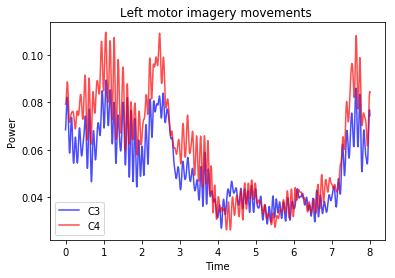

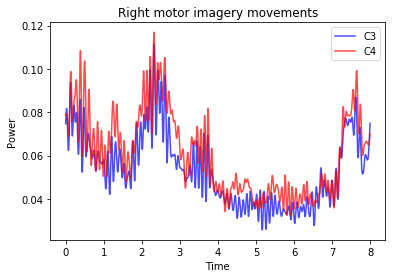

In [222]:
# specify some cutoff values for the visualization
lowcut_a, highcut_a = 14, 30
# and also an interval to display
interval_a = [0, 8]
# visualize logarithmic power?
logarithmic_power = False

# visualize the extracted trial from above
gumpy.plot.average_power(data_class_a, lowcut_a, highcut_a, interval_a, grazb_data.sampling_freq, logarithmic_power)

# Spectrogram 

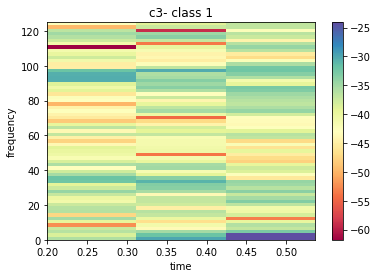

In [223]:
x=np.mean(data_class1[0], axis=1)
x.shape
FS=grazb_data.sampling_freq

xx, freqs, bins, im = plt.specgram(x , NFFT=128,   Fs=FS, noverlap=100, cmap=plt.get_cmap('Spectral'))
# print(y_subject[test][2000])
plt.title('c3- class 1')
plt.xlabel('time')
plt.ylabel('frequency')
plt.colorbar()
plt.show() 

## Wavelet transform
``gumpy`` relies on ``pywt`` to compute wavelet transforms. Furthermore, it contains convenience functions to visualize the results of the discrete wavelet transform as shown in the example below for the Graz dataset and the classes extracted above.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3b45521438>,
      dtype=object)

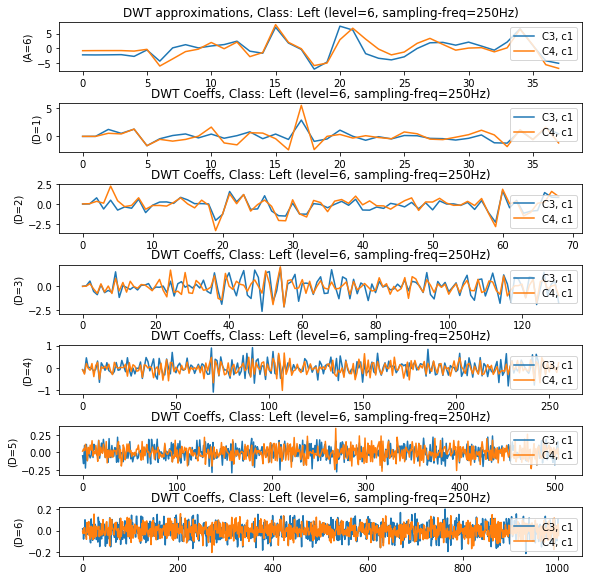

In [224]:
# As with most functions, you can pass arguments to a 
# gumpy function that will be forwarded to the backend.
# In this example the decomposition levels are mandatory, and the 
# mother wavelet that should be passed is optional
level = 6
wavelet = 'db4'

# now we can retrieve the dwt for the different channels
mean_coeff_ch0_c1 = gumpy.signal.dwt(data_class1[0], level=level, wavelet=wavelet)
mean_coeff_ch1_c1 = gumpy.signal.dwt(data_class1[1], level=level, wavelet=wavelet)
mean_coeff_ch0_c2 = gumpy.signal.dwt(data_class1[3], level=level, wavelet=wavelet)
mean_coeff_ch1_c2 = gumpy.signal.dwt(data_class1[4], level=level, wavelet=wavelet)

# gumpy's signal.dwt function returns the approximation of the 
# coefficients as first result, and all the coefficient details as list
# as second return value (this is contrast to the backend, which returns
# the entire set of coefficients as a single list)
approximation_C3 = mean_coeff_ch0_c2[0]
approximation_C4 = mean_coeff_ch1_c2[0]

# as mentioned in the comment above, the list of details are in the second
# return value of gumpy.signal.dwt. Here we save them to additional variables
# to improve clarity
details_c3_c1 = mean_coeff_ch0_c1[1]
details_c4_c1 = mean_coeff_ch1_c1[1]
details_c3_c2 = mean_coeff_ch0_c2[1]
details_c4_c2 = mean_coeff_ch1_c2[1]

# gumpy exhibits a function to plot the dwt results. You must pass three lists,
# i.e. the labels of the data, the approximations, as well as the detailed coeffs,
# so that gumpy can automatically generate appropriate titles and labels.
# you can pass an additional class string that will be incorporated into the title.
# the function returns a matplotlib axis object in case you want to further
# customize the plot.
gumpy.plot.dwt(
    [approximation_C3, approximation_C4],
    [details_c3_c1, details_c4_c1],
    ['C3, c1', 'C4, c1'],
    level, grazb_data.sampling_freq, 'Class: Left')